<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment" data-toc-modified-id="Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li></ul></div>

# Human Activity Recognition - Baselines

Last Update : 21 July 2019

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/conv


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import h5py


import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset

In [4]:
from utils.data.tsdata import get_timeseries_dataset

data_train = get_timeseries_dataset("har")(split="train", is_fill_mean=True, data_perc=1)
data_test = get_timeseries_dataset("har")(split="test", is_fill_mean=True, data_perc=1)

In [5]:
np.unique(data_test.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([496, 471, 420, 491, 532, 537]))

In [6]:
# best acc
537 / len(data_test.targets)

0.18221920597217509

In [7]:
X_DIM = 1  # 1D spatial input (although actually 2 but the first is for sparse channels)
Y_DIM = data_train.data.shape[-1] # multiple channels
N_TARGETS = len(np.unique(data_train.targets))

sampling_percentages = [0.05, 0.1, 0.3, 0.5, 0.7, 1]

## Model

In [8]:
import torch.nn as nn
from skssl.predefined import RNN, MLP
from utils.helpers import count_parameters

In [9]:
class FeatureMLP(nn.Module):

    def __init__(self, input_size, output_size, **kwargs):
        super().__init__()
        self.out = MLP(input_size*4, output_size, **kwargs)

    def forward(self, X, y=None):

        if y is not None:
            # is there's y then that's the actual input and X is time
            X = y

        outputs = self.out(torch.cat([X.mean(-2), X.max(-2)[0], X.min(-2)[0], X.var(-2)], dim=-1))
        return outputs

In [10]:
models = {}

models["bi_rnn_delta"] = partial(RNN, input_size=Y_DIM, hidden_size=64, output_size=N_TARGETS, bidirectional=True, n_layers=1, dropout=0.5, is_add_delta=True)
models["feature_mlp"]  = partial(FeatureMLP, input_size=Y_DIM, output_size=N_TARGETS, hidden_size=128, dropout=0.5, n_hidden_layers=3, is_res=True)

In [11]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

bi_rnn_delta - N Param: 29574
feature_mlp - N Param: 38534


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


- selected best rnn from [GRU, LSTM], hidden [32,64,128], [bidirect,None], dropout [0,0.5], lr [1e-4,1e-3], layer [1,2]
- selected best feature MLP from hidden [32,64,128], n_hidden_layers [1,3], dropout [0,0.5], [is_res, None], lr [1e-4,1e-3]

all with early stoping patience 10, cross entropy, standardized data, 100 epochs, batch size 64

# Supervised Training with Missing Features

In [12]:
from ntbks_helpers import train_models_

In [13]:
N_EPOCHS = 100 
BATCH_SIZE = 64
IS_RETRAIN = False # if false load precomputed
chckpnt_dirname="results/challenge/har/"

In [14]:
data_trainers = {}

for perc in sampling_percentages:
    data_train = get_timeseries_dataset("har")(split="train", data_perc=perc, is_fill_mean=False)
    data_test = get_timeseries_dataset("har")(split="test", data_perc=perc, is_fill_mean=False)
    
    data_trainers.update(train_models_({"{}%har".format(int(perc*100)): (data_train, data_test)}, 
                             models, 
                             chckpnt_dirname=chckpnt_dirname,
                              max_epochs=N_EPOCHS,
                              batch_size=BATCH_SIZE,
                             is_retrain=IS_RETRAIN))


--- Loading 5%har/bi_rnn_delta ---

5%har/bi_rnn_delta best epoch: 9 val_loss: 0.5359820848704395

--- Loading 5%har/feature_mlp ---

5%har/feature_mlp best epoch: 18 val_loss: 0.5488887399708088

--- Loading 10%har/bi_rnn_delta ---

10%har/bi_rnn_delta best epoch: 9 val_loss: 0.3888445916646617

--- Loading 10%har/feature_mlp ---

10%har/feature_mlp best epoch: 16 val_loss: 0.4893241169030358

--- Loading 30%har/bi_rnn_delta ---

30%har/bi_rnn_delta best epoch: 18 val_loss: 0.25232738165437596

--- Loading 30%har/feature_mlp ---

30%har/feature_mlp best epoch: 15 val_loss: 0.41251740123524194

--- Loading 50%har/bi_rnn_delta ---

50%har/bi_rnn_delta best epoch: 19 val_loss: 0.21550011958437157

--- Loading 50%har/feature_mlp ---

50%har/feature_mlp best epoch: 15 val_loss: 0.38914211493328055

--- Loading 70%har/bi_rnn_delta ---

70%har/bi_rnn_delta best epoch: 9 val_loss: 0.23589642063253485

--- Loading 70%har/feature_mlp ---

70%har/feature_mlp best epoch: 16 val_loss: 0.384192570

In [15]:
models2 = {}

models2["bi_rnn_meanfill"] = RNN(Y_DIM, 64, N_TARGETS, bidirectional=True, n_layers=1, is_add_delta=False)

In [16]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

bi_rnn_delta - N Param: 29574
feature_mlp - N Param: 38534


In [17]:
for perc in sampling_percentages:
    data_train = get_timeseries_dataset("har")(split="train", data_perc=perc, is_fill_mean=True)
    data_test = get_timeseries_dataset("har")(split="test", data_perc=perc, is_fill_mean=True)
    
    data_trainers.update(train_models_({"{}%har".format(int(perc*100)): (data_train, data_test)}, 
                             models2, 
                             chckpnt_dirname=chckpnt_dirname,
                              max_epochs=N_EPOCHS,
                              batch_size=BATCH_SIZE,
                             is_retrain=IS_RETRAIN))


--- Loading 5%har/bi_rnn_meanfill ---

5%har/bi_rnn_meanfill best epoch: 12 val_loss: 0.56304434497032

--- Loading 10%har/bi_rnn_meanfill ---

10%har/bi_rnn_meanfill best epoch: 1 val_loss: 0.46905726127890274

--- Loading 30%har/bi_rnn_meanfill ---

30%har/bi_rnn_meanfill best epoch: 10 val_loss: 0.3455855598035093

--- Loading 50%har/bi_rnn_meanfill ---

50%har/bi_rnn_meanfill best epoch: 1 val_loss: 0.323673616881123

--- Loading 70%har/bi_rnn_meanfill ---

70%har/bi_rnn_meanfill best epoch: 8 val_loss: 0.3046555771518627

--- Loading 100%har/bi_rnn_meanfill ---

100%har/bi_rnn_meanfill best epoch: 6 val_loss: 0.29275460707603823


# No Joint

In [18]:
from skssl.transformers.neuralproc.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.1, max_n_indcs=0.5),
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt_feat = CntxtTrgtGetter(contexts_getter=get_all_indcs,
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes


get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.5, max_n_indcs=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

In [19]:
data_train = get_timeseries_dataset("har")(split="train")
data_test = get_timeseries_dataset("har")(split="test")
data_both = get_timeseries_dataset("har")(split="both")

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False):
    def mycollate(batch):
        min_length = min([v.size(0) for b in batch for k,v in b[0].items() if "X" in k])
        # chose first min_legth of each (assumes that randomized)
        
        batch = [({k:v[:min_length, ...] for k,v in b[0].items()}, b[1]) for b in batch]        
        collated = torch.utils.data.dataloader.default_collate(batch)
        
        X = collated[0]["X"]
        y = collated[0]["y"]
        
        if is_repeat_batch:
            
            X = torch.cat([X,X], dim=0)
            y = torch.cat([y,y], dim=0)
        
        collated[0]["X"], collated[0]["y"], collated[0]["X_trgt"], collated[0]["y_trgt"] = get_cntxt_trgt(X, y)
        
        return collated
    return mycollate

In [20]:
import torch.nn as nn
from skssl.transformers import GlobalNeuralProcess, NeuralProcessLoss, AttentiveNeuralProcess
from skssl.utils.helpers import rescale_range
from skssl.predefined import UnetCNN, CNN, MLP, SparseSetConv, SetConv, MlpRBF, GaussianRBF, BatchSparseSetConv
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split
from utils.helpers import count_parameters

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [22]:
import torch.nn as nn
from skssl.predefined import RNN, MLP

In [23]:
class FeatureMLP(nn.Module):

    def __init__(self, feat_size, y_dim, output_size, **kwargs):
        super().__init__()
        self.out = MLP(feat_size+y_dim*4, output_size, **kwargs)

    def forward(self, X, X_feat, y=None):

        if y is not None:
            # is there's y then that's the actual input and X is time
            X = y

        outputs = self.out(torch.cat([X_feat, X.mean(-2), X.max(-2)[0], X.min(-2)[0], X.var(-2)], dim=-1))
        return outputs

In [24]:
datas = {p:get_timeseries_dataset("har")(split="both", data_perc=p, is_fill_mean=False)
         for p in sampling_percentages}

In [25]:
models = dict(mlp_hand = partial(FeatureMLP, feat_size=256, y_dim=Y_DIM, output_size=N_TARGETS, hidden_size=128, 
                dropout=0.5, n_hidden_layers=3, is_res=True))

In [26]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

mlp_hand - N Param: 71302


In [27]:
from skorch.dataset import Dataset

In [28]:
def train_eval_on_featurized(X_train, X_test, Y_train, Y_test):
    mlp = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(128,))
    mlp = SVC()
    mlp.fit(X_train, Y_train)
    print(mlp.score(X_test, Y_test))

In [29]:


ks = ["5%har/transformer_gnp_large_shared_bottleneck", 
     "10%har/transformer_gnp_large_shared_bottleneck",
     "30%har/transformer_gnp_large_shared_bottleneck",
     "50%har/transformer_gnp_large_shared_bottleneck",
     "70%har/transformer_gnp_large_shared_bottleneck",
     "100%har/transformer_gnp_large_shared_bottleneck"]

for k in ks:
    perc = float(k.split("%")[0]) / 100
    n_train = datas[perc].n_train
    model_name = k.split("/")[1]
    y = datas[perc].targets
    transformed_data = np.load(chckpnt_dirname+k+"/transformed_data.npy", allow_pickle=False)
    
    X_train, X_test, Y_train, Y_test = transformed_data[:n_train], transformed_data[n_train:], y[:n_train].squeeze(), y[n_train:].squeeze()
    
    #train_eval_on_featurized(X_train, X_test, Y_train, Y_test)
                                               
    data_trainers.update(train_models_({"{}%har".format(int(perc*100)): (Dataset(X={"X_feat":X_train.astype(np.float32), 
                                                                   "X":datas[perc].data[:n_train].astype(np.float32)}, 
                                                                y=torch.from_numpy(Y_train).long()), 
                                                        Dataset(X={"X_feat":X_test.astype(np.float32), 
                                                                   "X":datas[perc].data[n_train:].astype(np.float32)}, 
                                                                y=torch.from_numpy(Y_test).long()))}, 
                                               {model_name +"/feat_"+ name: partial(m, feat_size=X_train.shape[-1]) for name,m in models.items()}, 
                                                 chckpnt_dirname=chckpnt_dirname,
                                                  max_epochs=N_EPOCHS,
                                                  batch_size=BATCH_SIZE,
                                                 is_retrain=IS_RETRAIN,
                                                callbacks=[]))
    
    


--- Loading 5%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

5%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 73 val_loss: 0.38785125635258416

--- Loading 10%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

10%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 44 val_loss: 0.31841600827131994

--- Loading 30%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

30%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 43 val_loss: 0.17624642762403225

--- Loading 50%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

50%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 14 val_loss: 0.16361097501502977

--- Loading 70%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

70%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 21 val_loss: 0.12425847081032582

--- Loading 100%har/transformer_gnp_large_shared_bottleneck/feat_mlp_hand --

In [30]:
for k,t in data_trainers.items():
    for e, h in enumerate(t.history[::-1]):
        if h["valid_loss_best"]:
            print(k, "epoch:", len(t.history)-e, 
                  "val_loss:", h["valid_loss"], 
                  "val_acc:", h["valid_acc"])
            break

5%har/bi_rnn_delta epoch: 9 val_loss: 0.5359820848704395 val_acc: 0.8082796063793688
5%har/feature_mlp epoch: 18 val_loss: 0.5488887399708088 val_acc: 0.7712928401764506
10%har/bi_rnn_delta epoch: 9 val_loss: 0.3888445916646617 val_acc: 0.8625721072276892
10%har/feature_mlp epoch: 16 val_loss: 0.4893241169030358 val_acc: 0.8004750593824228
30%har/bi_rnn_delta epoch: 18 val_loss: 0.25232738165437596 val_acc: 0.9049881235154394
30%har/feature_mlp epoch: 15 val_loss: 0.41251740123524194 val_acc: 0.8391584662368511
50%har/bi_rnn_delta epoch: 19 val_loss: 0.21550011958437157 val_acc: 0.9229725144214456
50%har/feature_mlp epoch: 15 val_loss: 0.38914211493328055 val_acc: 0.8568035290125552
70%har/bi_rnn_delta epoch: 9 val_loss: 0.23589642063253485 val_acc: 0.9131319986426875
70%har/feature_mlp epoch: 16 val_loss: 0.38419257051304795 val_acc: 0.8574821852731591
100%har/bi_rnn_delta epoch: 16 val_loss: 0.204064313460102 val_acc: 0.9229725144214456
100%har/feature_mlp epoch: 24 val_loss: 0.37777

In [31]:
import pandas as pd

out = pd.Series({k:v.history[-1]["valid_acc"] for k,v in data_trainers.items()}).reset_index(name="accuracy")
splitted = out["index"].str.split("/", expand = True)
out["meta"] = splitted[0]
out["models"] = splitted[1]

splitted2 = out["meta"].str.split("har", expand = True)
out["data sample"] = splitted2[0]

out.drop(columns =["index"], inplace = True) 

out = out.groupby(["models", "data sample"]).mean()




#http://localhost:8898/notebooks/notebooks/Human%20Activity%20Recognition%20-%20GNP%20JOINT%20NEW.ipynb#: 
df=pd.DataFrame([["10%", 0.902047], ["100%",0.976021], ["30%",0.957245], ["5%",0.820269], ["50%",0.963353], ["70%", 0.975908]], 
             columns=["data sample", "accuracy"])
df.index = ["Joint UnetNP"] * len(df)
df.index.name = "models"
df = df.set_index("data sample", append=True)

df = pd.concat((out, df), axis=0)

df.rename(index = {"bi_rnn_delta": "BiRNN Interval", 
                     "bi_rnn_meanfill":"BiRNN Mean Fill",
                     "feature_mlp":"Simple Features",
                     "transformer_gnp_large_shared_bottleneck":"UnetNP Features"},
                                 inplace = True)
df.reset_index(drop=False, inplace=True)
df["data sample"] = df["data sample"].map(lambda x: int(str(x)[:-1]))
df=df.rename(columns={"models":"Models", "accuracy":"Accuracy", "data sample":"Sample Percentage (%)"})

#df=df.pivot_table(values="accuracy", index=["data sample"], columns=["models"])
#df=df.sort_index()


In [32]:
df["Sample Percentage (%)"].unique()

array([ 10, 100,  30,   5,  50,  70])

In [33]:
import seaborn as sns

Text(5, 0.945, '100% Data\n    SOTA')

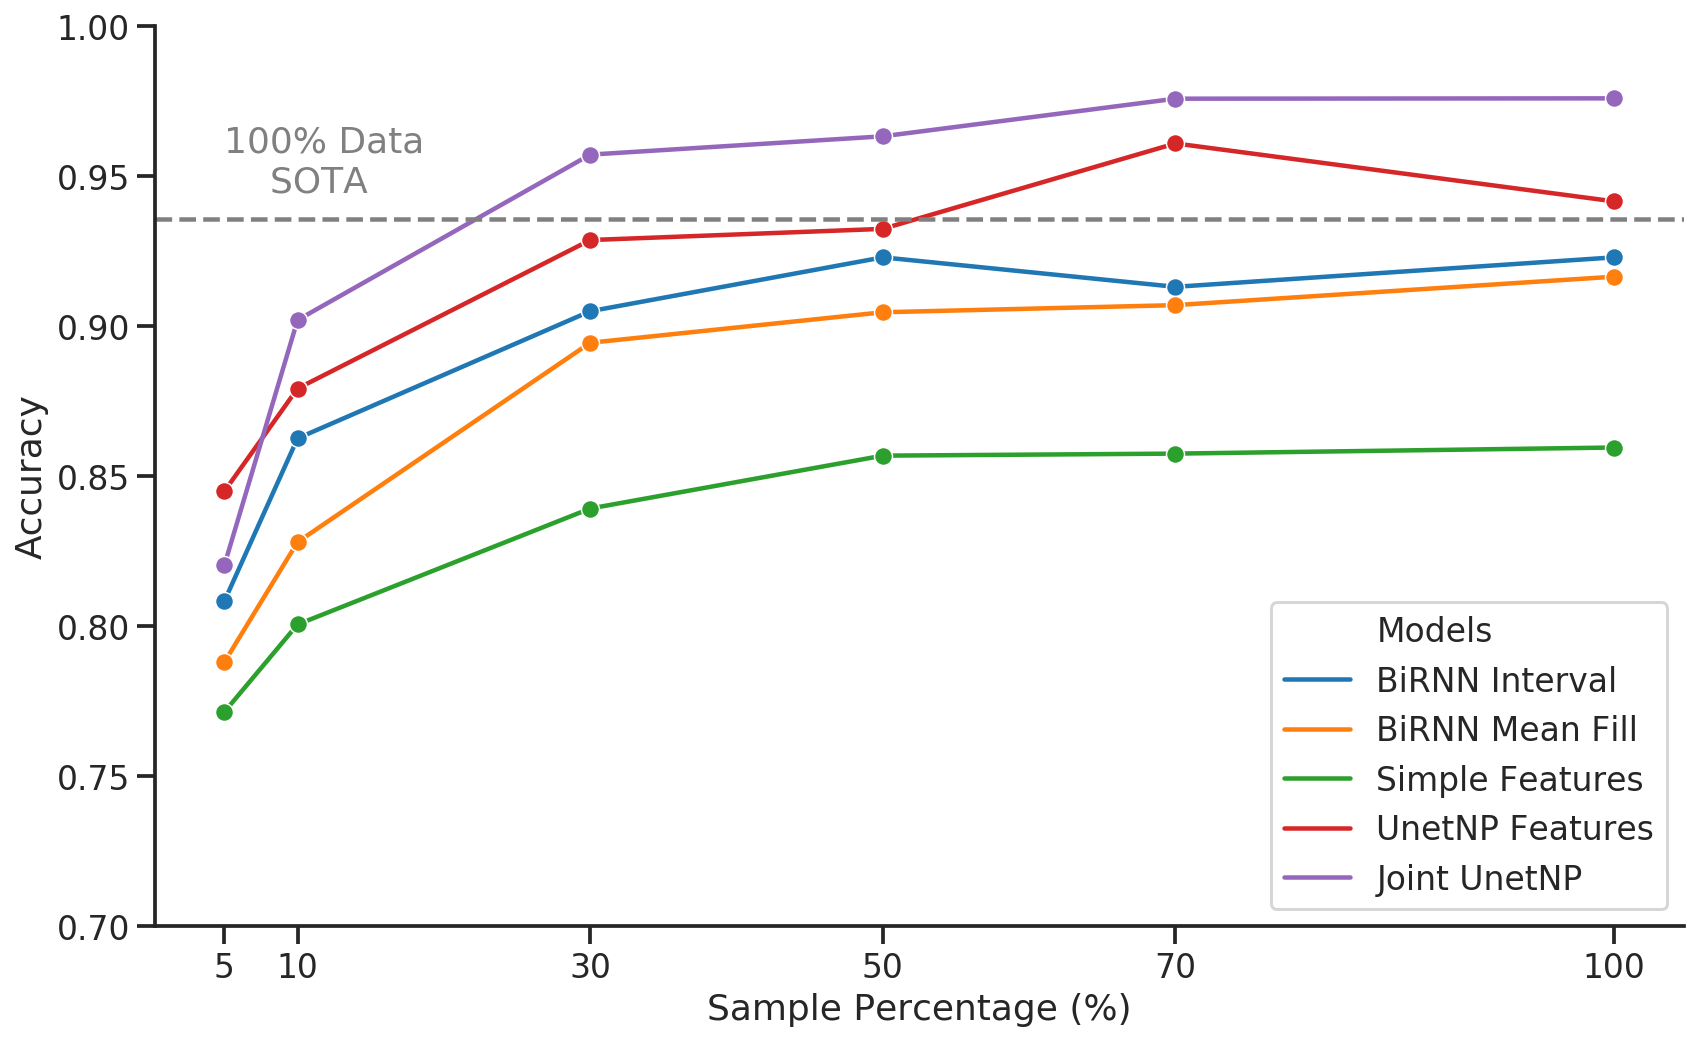

In [35]:
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots(1,1, figsize=(13.7,8.27))
sns.set_style("white")
sns.set_context("talk")
sns.lineplot(data=df, x="Sample Percentage (%)", y="Accuracy", hue="Models", marker="o", ax=ax)
ax.set_xticks(df["Sample Percentage (%)"].unique())
ax.set_ylim([0.7,1])
sns.despine()
ax.axhline(0.9357, ls='--', c="gray")
ax.text(5,0.945, "100% Data\n    SOTA", c="gray")

Text(5, 0.95, 'SOTA')

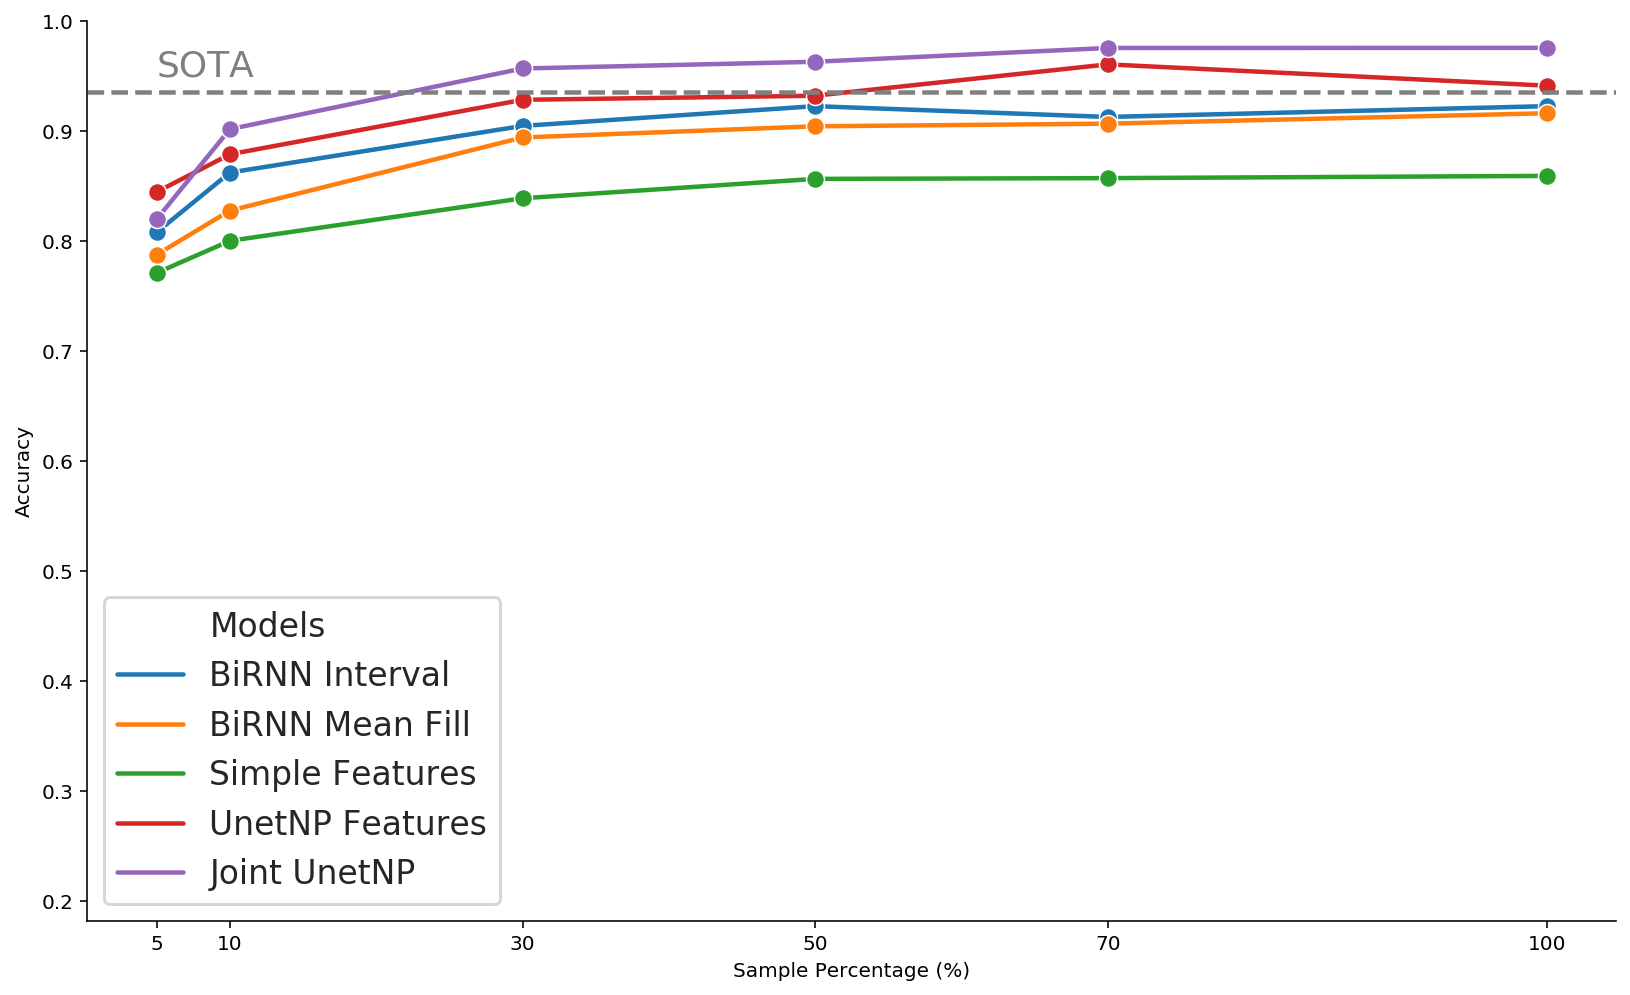

In [46]:
fig, ax = plt.subplots(1,1, figsize=(13.7,8.27))
sns.set_style("white")
sns.set_context("talk")
sns.lineplot(data=df, x="Sample Percentage (%)", y="Accuracy", hue="Models", marker="o", ax=ax)
ax.set_xticks(df["Sample Percentage (%)"].unique())
ax.set_ylim([0.182,1])
sns.despine()
ax.axhline(0.9357, ls='--', c="gray")
ax.text(5,0.95, "SOTA", c="gray")

In [57]:
sns.

accuracy
models                                  data sample          
bi_rnn_delta                            10%          0.862572
                                        100%         0.922973
                                        30%          0.904988
                                        5%           0.808280
                                        50%          0.922973
                                        70%          0.913132
bi_rnn_meanfill                         10%          0.827961
                                        100%         0.916525
                                        30%          0.894469
                                        5%           0.787920
                                        50%          0.904649
                                        70%          0.907024
feature_mlp                             10%          0.800475
                                        100%         0.859518
                                        30%          0.839158
                                        5%           0.771293
                                        50%          0.856804
                                        70%          0.857482
transformer_gnp_large_shared_bottleneck 10%          0.879199
                                        100%         0.941636
                                        30%          0.928741
                                        5%           0.844927
                                        50%          0.932474
                                        70%          0.960977